# Downloading Data from Kaggle

To download the dataset from Kaggle, you need the kaggle.json file that contains your username and api key. In order to obtain that, just follow this link: https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/ and download it.

Once you have it, you need to copy '.env.example' and rename it to '.env'.

Then place your username and api key in the .env folder from kaggle.json file.

Now you can proceed with downloading the data and preprocessing it.

At the end of this, you will be able to obtain processed data

In [ ]:
! pip install kaggle -q
! pip install python-dotenv -q

In [19]:
import dotenv
import os
import zipfile

In [4]:
dotenv.load_dotenv()

True

In [15]:
json_content = '{"username":' + f"\"{os.getenv('KAGGLE_USERNAME')}\"" + ',"key":' + f"\"{os.getenv('KAGGLE_KEY')}\"" + '}'
home = os.path.expanduser("~")
kaggle_path = os.path.join(home, '.kaggle')
try:
    os.makedirs(kaggle_path)
    with open(os.path.join(kaggle_path, 'kaggle.json'), 'w') as f:
        f.write(json_content)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

In [ ]:
! kaggle datasets download landfallmotto/covid19-vaccine-adverse-reactions-vaers-dataset

In [20]:
! mkdir data
with zipfile.ZipFile('covid19-vaccine-adverse-reactions-vaers-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

A subdirectory or file data already exists.


In [23]:
os.remove('covid19-vaccine-adverse-reactions-vaers-dataset.zip')

# Data Preprocessing

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
#Importing dataset
df = pd.read_csv('data/vaers_jan_nov_2021.csv')
df.head()

In [ ]:
# Check for null values
df.isna().sum()

In [ ]:
#Removing all JENSSEN vaccine information
vaers = df.loc[df['VAX_MANU'].str.contains('PFIZER|MODERNA')]
len(vaers)

805478

In [ ]:
#Removing useless features
vaers = vaers[['VAERS_ID','SYMPTOM1','VAX_MANU', 'AGE_YRS', 'SEX',]]
len(vaers)

805478

In [ ]:
#Removing null and empty values drom dataset
vaers = vaers.dropna()
len(vaers)

746337

In [ ]:
#Removing duplicate ID fields
vaers = vaers.drop_duplicates(subset=['VAERS_ID'], keep=False)
len(vaers)

368441

In [ ]:
#Removing no adverse event rows
vaers = vaers[~vaers.SYMPTOM1.str.contains("No adverse event")]
len(vaers)

365114

In [ ]:
#Removing unknown sex/gender rows
vaers = vaers[~vaers.SEX.str.contains("U")]
len(vaers)

362014

In [ ]:
vaers['AGE_YRS'] = vaers['AGE_YRS'].apply(np.ceil)
vaers.head()

In [ ]:
#Finiding outliers of age
Q1 = vaers['AGE_YRS'].quantile(0.25)
Q3 = vaers['AGE_YRS'].quantile(0.75)
IQR = Q3 - Q1
Lower_Fence = Q1 - (1.5 * IQR)
Upper_Fence = Q3 + (1.5 * IQR)
print(IQR)
print(Lower_Fence)
print(Upper_Fence)

30.0
-10.0
110.0


In [ ]:
#Removing Outliers the data set
vaers = vaers[~((vaers['AGE_YRS'] < Lower_Fence) |(vaers['AGE_YRS'] > Upper_Fence))]
len(vaers)

362006

In [ ]:
# Changing the names of columns
vaers = vaers.rename(columns={'VAERS_ID':'ID', 'VAX_MANU':'Vaccine', 'AGE_YRS':'Age', 'SEX':'Sex', 'SYMPTOM1':'Side_Effect'})
vaers.head()

,ID,Side_Effect,Vaccine,Age,Sex
0,916600,Dysphagia,MODERNA,33.0,F
1,916601,Anxiety,MODERNA,73.0,F
2,916602,Chest discomfort,PFIZER\BIONTECH,23.0,F
3,916603,Dizziness,MODERNA,58.0,F
4,916604,Injection site erythema,MODERNA,47.0,F


In [ ]:
c = vaers.groupby(['Side_Effect'])['ID'].count().nlargest(100)

In [ ]:
count = vaers['Vaccine'].value_counts()

In [ ]:
count = vaers['Age'].value_counts()

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(c)

In [ ]:
temp = vaers.copy()

In [ ]:
vaers = temp.copy()
vaers

##Feature Extraction

In [ ]:
! pip install fuzzywuzzy -q
! pip install python-Levenshtein -q

     |████████████████████████████████| 50 kB 2.8 MB/s 


In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [ ]:
# Side Effects based on most common side effects of Covid 19 according 
# to https://www.cdc.gov/coronavirus/2019-ncov/vaccines/expect/after.html
# More side effects can bee added to 'side_effects' list, but it might affect 
# the overall accuracy and performance
side_effects = ['Headache', 'Pain', 'Swelling']
print(side_effects)

['Headache', 'Pain', 'Swelling']


In [ ]:
# Function to perform string matching
def checker(wrong_options,correct_options):
  names_array=[]
  ratio_array=[]
  for wrong_option in wrong_options:
      if wrong_option in correct_options:
          names_array.append(wrong_option)
          ratio_array.append('100')
      else:   
          x=process.extractOne(wrong_option,correct_options,scorer=fuzz.token_set_ratio, score_cutoff=90)
          if (x != None):
            names_array.append(x[0])
            ratio_array.append(x[1])
          else:
            names_array.append(None)
            ratio_array.append(None)
  return names_array,ratio_array

In [ ]:
# Convert symptoms table to list
str2Match = vaers['Side_Effect'].tolist()
strOptions = side_effects

In [ ]:
# Perform string matching on symptoms column
name_match,ratio_match=checker(str2Match,strOptions)

In [ ]:
# Replace the symptoms with the newly matched ones
vaers['Side_Effect'] = pd.Series(name_match)
len(vaers)

362006

##Final DataFrame

In [ ]:
#Removing NaN values
vaers = vaers.dropna()
vaers = vaers.reset_index(drop=True)
len(vaers)

19743

In [ ]:
#Confirm if any column has NaN value
vaers.isna().any()

ID             False
Side_Effect    False
Vaccine        False
Age            False
Sex            False
dtype: bool

In [ ]:
# Extract the processed dataset, download it and then save it in your google drive under vaers folder
vaers.to_csv(r'data/processed_vaers_dataset.csv', index = False)

#Random Forest Classification

In [ ]:
! pip install tensorflow_decision_forests -q
! pip install wurlitzer -q

In [ ]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

In [ ]:
# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

## Data Preperation

In [ ]:
# using One-Hot Encoder to generate binary values using get_dummies
vaers_rf = pd.get_dummies(vaers, columns=["Vaccine", "Sex"])
vaers_rf = vaers_rf.iloc[:,1:7]
vaers_rf = vaers_rf.astype({"Age": int, "Vaccine_MODERNA": int, "Vaccine_PFIZER\BIONTECH": int, "Sex_F": int, "Sex_M": int})
vaers_rf

In [ ]:
# Encode the categorical label into an integer.
#
# Details:
# This stage is necessary if your classification label is represented as a
# string. Note: Keras expected classification labels to be integers.

# Name of the label column.
label = "Side_Effect"

classes = vaers_rf[label].unique().tolist()
print(f"Label classes: {classes}")

vaers_rf[label] = vaers_rf[label].map(classes.index)

Label classes: ['Swelling', 'Pain', 'Headache']


In [ ]:
# Split the dataset into a training and a testing dataset.

def split_dataset(dataset, test_ratio=0.20):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(vaers_rf)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

15900 examples in training, 3843 examples for testing.


In [ ]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

## Model Training

In [ ]:
%set_cell_height 300

# Specify the model.
rf_model = tfdf.keras.RandomForestModel()

# Optionally, add evaluation metrics.
rf_model.compile(
    metrics=["accuracy"])

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
  rf_model.fit(x=train_ds)

<IPython.core.display.Javascript object>

Use /tmp/tmp5dt8vbdl as temporary training directory
Starting reading the dataset
13/16 [=======================>......] - ETA: 0s
Dataset read in 0:00:00.250674
Training model
Model trained in 0:00:05.800333
Compiling model
16/16 [==============================] - 7s 422ms/step


In [ ]:
# Summary of the Model
%set_cell_height 300
rf_model.summary()

<IPython.core.display.Javascript object>

Model: "random_forest_model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (5):
	Age
	Sex_F
	Sex_M
	Vaccine_MODERNA
	Vaccine_PFIZER\BIONTECH

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                 "__LABEL" 10.524953 ################
    2.         "Vaccine_MODERNA"  7.958856 ############
    3. "Vaccine_PFIZER\BIONTECH"  7.815764 ###########
    4.                   "Sex_M"  7.281301 ##########
    5.                   "Sex_F"  7.161899 ##########
    6.                     "Age"  0.188107 

Variable Importance: NUM_AS_ROOT:
    1.                     "Age" 245.000000 ################
    2.                   "Sex_M" 22.000000 #
    3.                   "Sex_F" 17.000000 
    4. "Va

## Model Evaluation

In [ ]:
# Model Evaluation on Test dataset
evaluation = rf_model.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

4/4 [==============================] - 0s 58ms/step - loss: 0.0000e+00 - accuracy: 0.6211

loss: 0.0000
accuracy: 0.6211


In [ ]:
# General Evaluation of the model
rf_model.make_inspector().evaluation()

Evaluation(num_examples=15900, accuracy=0.6240880503144655, loss=11.09398892861012, rmse=None, ndcg=None, aucs=None)

## Save Model and Graph Plotting

In [ ]:
! mkdir model

In [ ]:
# Save Model
rf_model.save("model/RFModel")

In [ ]:
# Random Forest Tree plotter, each box represents a Tree Node
tfdf.model_plotter.plot_model_in_colab(rf_model, tree_idx=0, max_depth=3)

<Figure size 864x288 with 0 Axes>

Text(0.5, 0, 'Number of trees')

Text(0, 0.5, 'Accuracy (out-of-bag)')

Text(0.5, 0, 'Number of trees')

Text(0, 0.5, 'Logloss (out-of-bag)')

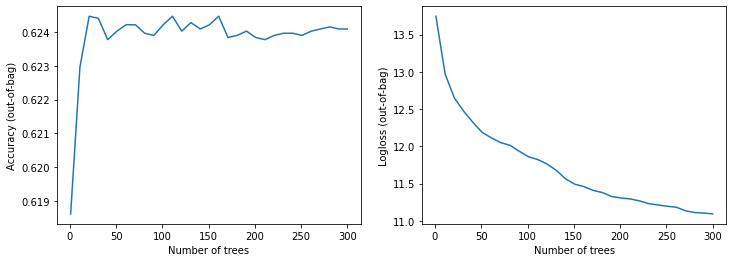

In [ ]:
# Plotting Accuracy and Loss of the model
import matplotlib.pyplot as plt

logs = rf_model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

# LSTM Model Training

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import plotly.graph_objs as go
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

## Data Preperation

In [ ]:
# The maximum number of side effects to be determined. (most frequent)
MAX_NB_SIDE = 5000
# This is fixed.
EMBEDDING_DIM = 100

In [ ]:
# using One-Hot Encoder to generate binary values using get_dummies
vaers_lstm = pd.get_dummies(vaers, columns=["Vaccine", "Sex"])
vaers_lstm

In [ ]:
X = vaers_lstm.iloc[:,2:7].values
print('Shape of data tensor:', X.shape)

Shape of data tensor: (19743, 5)


In [ ]:
Y = pd.get_dummies(vaers_lstm['Side_Effect']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (19743, 3)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(15794, 5) (15794, 3)
(3949, 5) (3949, 3)


## Model Training

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_SIDE, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='relu'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

## Model Evaluation

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

124/124 [==============================] - 0s 3ms/step - loss: 0.8932 - accuracy: 0.6280
Test set
  Loss: 0.893
  Accuracy: 0.628


## Saving Model and Graph Plotting

In [ ]:
! mkdir model

In [ ]:
# Save Model
model.save("model/LSTMModel")

INFO:tensorflow:Assets written to: model/LSTMModel/assets


INFO:tensorflow:Assets written to: model/LSTMModel/assets


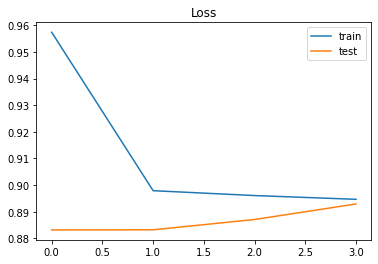

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

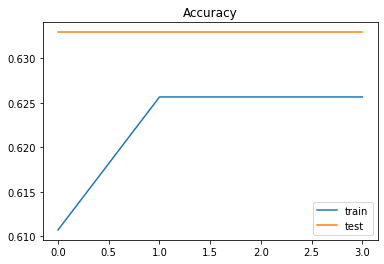

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
# Predict the symptom using new data
new_data = [['36', '1', '0', '1', '0']] # Age, MODRENA, PFIZER, FEMALE, MALE
new_data = np.asarray(new_data).astype(np.float32)
pred = model.predict(new_data)
labels = ['Headache', 'Pain', 'Swelling']
print(pred, labels[np.argmax(pred)])

[[0.14577474 0.3763443  0.08911598]] Pain
